In [5]:
import ccdproc
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
from astropy.stats import mad_std

In [6]:
# import the bias frames
biasList = ['./UH88 Tek RAW DATA/tek001.fits', './UH88 Tek RAW DATA/tek002.fits', './UH88 Tek RAW DATA/tek003.fits', './UH88 Tek RAW DATA/tek004.fits', './UH88 Tek RAW DATA/tek005.fits', './UH88 Tek RAW DATA/tek006.fits', './UH88 Tek RAW DATA/tek007.fits', './UH88 Tek RAW DATA/tek008.fits', './UH88 Tek RAW DATA/tek009.fits', './UH88 Tek RAW DATA/tek010.fits']

# having CCDData read in and append all of the bias frames
biasFrames = [CCDData.read(filename, unit='adu') for filename in biasList]

# applying overscan correction with a function
def overscanCorrection(fileName):
    biasCorrected = ccdproc.subtract_overscan(fileName, overscan=fileName[2049:2080, :], overscan_axis=0, median=True)
    return biasCorrected

# applying trim with a function
def overscanTrim(fileName):
    biasTrimmed = ccdproc.trim_image(fileName[:2048, :2048])
    return biasTrimmed

# finally calling all of the functions for each biasframe in a for loop
biasCorrected = [overscanCorrection(frame) for frame in biasFrames]
biasTrimmed = [overscanTrim(frame) for frame in biasCorrected]

(2068, 2080)
(2048, 2048)


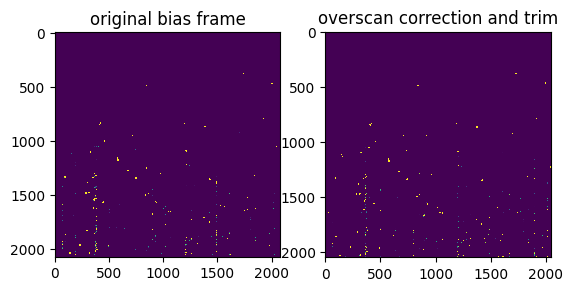

In [7]:
# checking if the previous cell worked
plt.subplot(1, 2, 1)
plt.imshow(biasCorrected[0], vmin=2.4, vmax=2.9)
plt.title('original bias frame')
plt.subplot(1, 2, 2)
plt.imshow(biasTrimmed[0], vmin=2.4, vmax=2.9)
plt.title('overscan correction and trim')
# plt.colorbar()

# printing the shapes, providing a different method of if it worked
print(biasFrames[0].data.shape)
print(biasTrimmed[0].data.shape)

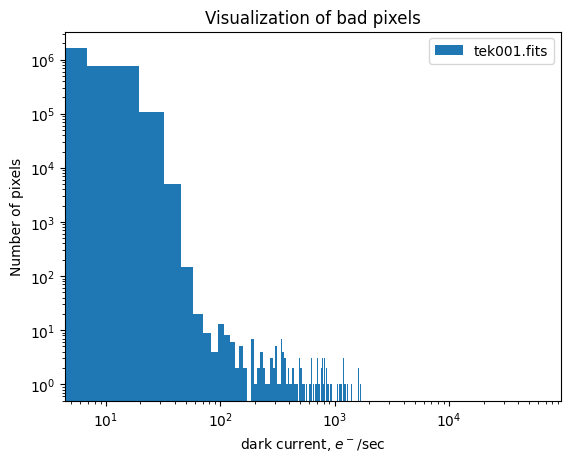

In [8]:
# looking at which pixel values are "bad" using tek001.fits with a histogram
plt.hist(biasTrimmed[0].data.flatten(), bins=5000, density=False, label='tek001.fits')
plt.title("Visualization of bad pixels")
plt.xlabel('dark current, $e^-$/sec')
plt.ylabel('Number of pixels')
plt.legend()
plt.loglog()
plt.show()

# looks like everything is pretty consistent until 10^2, we'll define everything after that to be "bad", and everything else to be 'good'

In [9]:
# isolating the good pixels, first with a boolean array
goodPixels = (biasTrimmed[0].data < 10e+2)
print('number of good pixels:', goodPixels.sum())

# double checking the median by defining good pixels with sigma clipping?
goodP = sigma_clip(biasTrimmed[0], sigma=3, axis=0)

# array of the actual values
goodPix = []
for i in biasTrimmed[0].data.flatten():
    if(i < 10e+2):
        goodPix.append(i)

# median
print('median of good pixels:', np.median(goodPix))
print('median of good pixels (w/sigma clipping):', np.median(goodP))

# stdev
print('stdev of good pixels:', np.std(goodPix))

# fraction
goodPixFrac = goodPixels.sum()/((biasTrimmed[0].data > 10e+2) + goodPixels).sum()
print('fraction of good pixels:', goodPixFrac)

# read noise
goodPixMean = np.mean(goodPix)
rd = 0
for i in goodPix:
    rd += (i - goodPixMean)**2/(len(goodPix) - 1)
rd = np.sqrt(rd)
print('read noise:', rd)
# why is the read noise equation the same as the stdev? edit: i think theyre the same tbh

number of good pixels: 4194266
median of good pixels: -3.0
median of good pixels (w/sigma clipping): -3.0


/Users/neptoon/opt/anaconda3/envs/stenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


stdev of good pixels: 79.12538965939596
fraction of good pixels: 0.9999909400939941
read noise: 79.12539909225035


INFO: splitting each image into 8 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


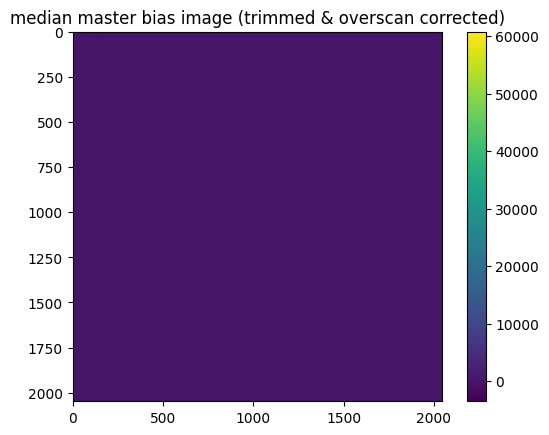

In [10]:
# making a median master bias image with the ccdproc.combine function
masterBias = ccdproc.combine(biasTrimmed, method='median', sigma_clip=True, sigma_clip_low_thresh=1, sigma_clip_high_thresh=1, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, mem_limit=350e6)

# saving as fits file
masterBias.write('masterBiasImage.fits', overwrite=True)

# plotting this thing to see if it worked
plt.imshow(masterBias)
plt.title('median master bias image (trimmed & overscan corrected)')
plt.colorbar()

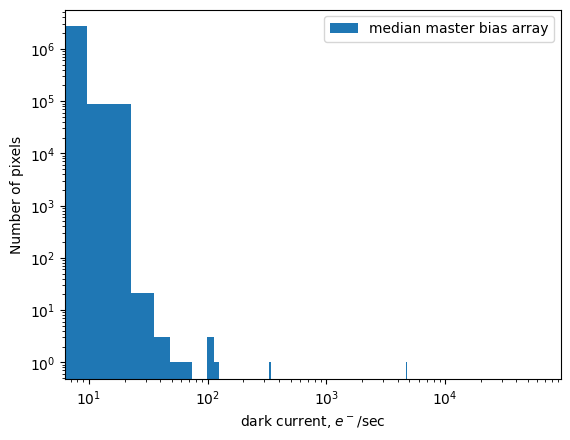

In [11]:
# let's do the same thing we did for a single bias frame
# looking at which pixel values are "bad" using a histogram
plt.hist(masterBias.data.flatten(), bins=5000, density=False, label='median master bias array')
plt.xlabel('dark current, $e^-$/sec')
plt.ylabel('Number of pixels')
plt.legend()
plt.loglog()
plt.show()

# things are weird right a little after 10^2, so lets do something like 9.5^2 to trim 

In [12]:
# isolating the good pixels, first with a boolean array
goodStackedPx = (masterBias.data < 9.5e+2)
print('number of good pixels:', goodStackedPx.sum())

# array of the actual values
goodStackedPix = []
for i in masterBias.data.flatten():
    if(i < 9.5e+2):
        goodStackedPix.append(i)

# median value of counts
print('median of good pixels in MMB image:', np.median(goodStackedPix))

# stdev of counts
print('stdev of good pixels in MMB image:', np.std(goodStackedPix))

number of good pixels: 4194301
median of good pixels in MMB image: -1.0
stdev of good pixels in MMB image: 78.44927063601335


In [13]:
# redoing the correction and trim functions because my life was made harder by 2 fits files that have already been overscan corrected and trimmed :eyetwitch:
# applying overscan correction
def overscanCorrectDome(fileName):
    biasCorrected = ccdproc.subtract_overscan(fileName, overscan=fileName[2049:2080, :], overscan_axis=0)
    return biasCorrected

# applying trim with a function
def overscanTrimDome(fileName):
    biasTrimmed = ccdproc.trim_image(fileName[:2048, :2048])
    return biasTrimmed

In [14]:
# applying bias and overscan corrections to dome flats
# import the dome flats
domeList = ['./UH88 Tek RAW DATA/tek011.fits', './UH88 Tek RAW DATA/tek012.fits', './UH88 Tek RAW DATA/tek013.fits', './UH88 Tek RAW DATA/tek014.fits', './UH88 Tek RAW DATA/tek015.fits', './UH88 Tek RAW DATA/tek016.fits', './UH88 Tek RAW DATA/tek017.fits', './UH88 Tek RAW DATA/tek018.fits', './UH88 Tek RAW DATA/tek019.fits', './UH88 Tek RAW DATA/tek020.fits', './UH88 Tek RAW DATA/tek021.fits', './UH88 Tek RAW DATA/tek022.fits', './UH88 Tek RAW DATA/tek023.fits', './UH88 Tek RAW DATA/tek024.fits', './UH88 Tek RAW DATA/tek025.fits']
# having CCDData read in and append all of the dome flats by filter
domeR = [CCDData.read(filename, unit='adu') for filename in domeList[:4]]
domeI = [CCDData.read(filename, unit='adu') for filename in domeList[5:9]]
# domeZ = [CCDData.read(filename, unit='adu') for filename in domeList[10:]]

# finally calling the functions defined in the cell above for the dome flats
domeCorrectedR = [overscanCorrection(frame) for frame in domeR]
domeCorrectedI = [overscanCorrection(frame) for frame in domeI]
# domeCorrectedZ = [overscanCorrection(frame) for frame in domeZ]

domeTrimmedR = [overscanTrim(frame) for frame in domeCorrectedR[:2]]
domeTrimmedR.insert(0, domeCorrectedR[1])
domeTrimmedR.insert(0, domeCorrectedR[0])
domeTrimmedI = [overscanTrim(frame) for frame in domeCorrectedI]
# domeTrimmedZ = [overscanTrim(frame) for frame in domeCorrectedZ]

# applying master bias image
domeFinalR = [ccdproc.subtract_bias(frame, masterBias) for frame in domeTrimmedR]
domeFinalI = [ccdproc.subtract_bias(frame, masterBias) for frame in domeTrimmedI]
# domeFinalZ = [ccdproc.subtract_bias(frame, masterBias) for frame in domeTrimmedZ]

/Users/neptoon/opt/anaconda3/envs/stenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/neptoon/opt/anaconda3/envs/stenv/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [15]:
# ok, doing this same exact thing for the sky flats
skyList = ['./UH88 Tek RAW DATA/tek026.fits', './UH88 Tek RAW DATA/tek027.fits', './UH88 Tek RAW DATA/tek028.fits', './UH88 Tek RAW DATA/tek029.fits', './UH88 Tek RAW DATA/tek030.fits', './UH88 Tek RAW DATA/tek031.fits', './UH88 Tek RAW DATA/tek032.fits', './UH88 Tek RAW DATA/tek033.fits', './UH88 Tek RAW DATA/tek034.fits', './UH88 Tek RAW DATA/tek035.fits', './UH88 Tek RAW DATA/tek036.fits', './UH88 Tek RAW DATA/tek037.fits', './UH88 Tek RAW DATA/tek038.fits', './UH88 Tek RAW DATA/tek039.fits', './UH88 Tek RAW DATA/tek040.fits', './UH88 Tek RAW DATA/tek041.fits']
# reading in and appending all sky flats for each filter
skyFlatsZ = [CCDData.read(filename, unit='adu') for filename in skyList[:5]]
skyFlatsR = [CCDData.read(filename, unit='adu') for filename in skyList[6:10]]
skyFlatsI = [CCDData.read(filename, unit='adu') for filename in skyList[11:]]

# calling the functions defined above
skyCorrectedZ = [overscanCorrectDome(frame) for frame in skyFlatsZ]
skyCorrectedR = [overscanCorrectDome(frame) for frame in skyFlatsR]
skyCorrectedI = [overscanCorrectDome(frame) for frame in skyFlatsI]

skyTrimmedZ = [overscanTrimDome(frame) for frame in skyCorrectedZ]
skyTrimmedR = [overscanTrimDome(frame) for frame in skyCorrectedR]
skyTrimmedI = [overscanTrimDome(frame) for frame in skyCorrectedI]

# applying master bias image
skyFinalR = [ccdproc.subtract_bias(frame, masterBias) for frame in skyTrimmedR]
skyFinalI = [ccdproc.subtract_bias(frame, masterBias) for frame in skyTrimmedI]
skyFinalZ = [ccdproc.subtract_bias(frame, masterBias) for frame in skyTrimmedZ]

In [20]:
# scaling the frames so they have the same median value with a function
def invMedian(a):
    return 1 / np.median(a)

def medDomeFlat(fileName, filter):
    # using the combine function used earlier
    masterDome = ccdproc.combine(fileName, method='median', scale=invMedian, sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, mem_limit=350e6)

    masterDome.write(f'medianDomeFlat{filter}.fits', overwrite=True)

    return masterDome

# calling this function for each filter
medDomeFlatR = medDomeFlat(domeFinalR, 'R')
medDomeFlatI = medDomeFlat(domeFinalI, 'I')
medDomeFlatZ = medDomeFlat(domeFinalZ, 'Z')

INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


/Users/neptoon/opt/anaconda3/envs/stenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/neptoon/opt/anaconda3/envs/stenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/neptoon/opt/anaconda3/envs/stenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/neptoon/opt/anaconda3/envs/stenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


NameError: name 'domeFinalZ' is not defined

In [19]:
# looking at pixel values so i can get rid of the doodoo pixels
plt.hist(medDomeFlatZ.data.flatten(), bins=5000, density=False, alpha=0.5, label='dome flat z')
plt.xlabel('dark current, $e^-$/sec')
plt.ylabel('Number of pixels')
plt.legend()
plt.loglog()
plt.show()
# everything after 10^3 is bad it seems

NameError: name 'medDomeFlatZ' is not defined

Text(0.5, 1.0, 'z filter')

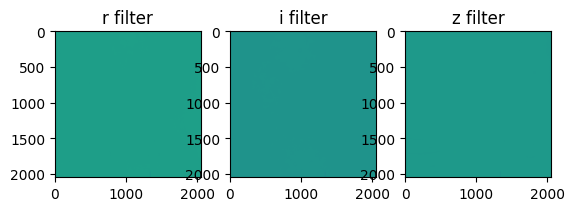

In [160]:
# plotting this thing to see if it worked
plt.subplot(1, 3, 1)
plt.imshow(medDomeFlatR)
plt.title('r filter')
plt.subplot(1, 3, 2)
plt.imshow(medDomeFlatI)
plt.title('i filter')
plt.subplot(1, 3, 3)
plt.imshow(medDomeFlatZ)
plt.title('z filter')

In [82]:
# applying the appropriate bias flat to the remaining images
# starting with separating each image by filter into separate arrays (referencing the .log output to determine which file belongs in each list)
iFilterList = ['./UH88 Tek RAW DATA/tek081.fits', './UH88 Tek RAW DATA/tek082.fits', './UH88 Tek RAW DATA/tek083.fits', './UH88 Tek RAW DATA/tek084.fits', './UH88 Tek RAW DATA/tek085.fits']
rFilterList = ['./UH88 Tek RAW DATA/tek091.fits', './UH88 Tek RAW DATA/tek092.fits', './UH88 Tek RAW DATA/tek093.fits', './UH88 Tek RAW DATA/tek094.fits', './UH88 Tek RAW DATA/tek095.fits']
# zFilterList = ['./UH88 Tek RAW DATA/tek154.fits', './UH88 Tek RAW DATA/tek155.fits', './UH88 Tek RAW DATA/tek156.fits', './UH88 Tek RAW DATA/tek157.fits', './UH88 Tek RAW DATA/tek158.fits', './UH88 Tek RAW DATA/tek168.fits', './UH88 Tek RAW DATA/tek172.fits']

# having CCDData read everything in
iFilter = [CCDData.read(filename, unit='adu') for filename in iFilterList]
rFilter = [CCDData.read(filename, unit='adu') for filename in rFilterList]
# zFilter = [CCDData.read(filename, unit='adu') for filename in zFilterList]

# applying trim and overscan correction to each
imgCorrectedR = [overscanCorrectDome(frame) for frame in rFilter]
imgCorrectedI = [overscanCorrectDome(frame) for frame in iFilter]
# imgCorrectedZ = [overscanCorrectDome(frame) for frame in zFilter]

# imgTrimmedZ = [overscanTrimDome(frame) for frame in imgCorrectedZ]
imgTrimmedR = [overscanTrimDome(frame) for frame in imgCorrectedR]
imgTrimmedI = [overscanTrimDome(frame) for frame in imgCorrectedI]

# applying master bias image
imgFinalR = [ccdproc.subtract_bias(frame, masterBias) for frame in imgTrimmedR]
imgFinalI = [ccdproc.subtract_bias(frame, masterBias) for frame in imgTrimmedI]
# imgFinalZ = [ccdproc.subtract_bias(frame, masterBias) for frame in imgTrimmedZ]

In [56]:
smoothR = [ccdproc.median_filter(file, size=20) for file in imgFinalR]
smoothI = [ccdproc.median_filter(file, size=20) for file in imgFinalI]

In [84]:
for i in range(len(imgFinalR)):
    imgFinalR[i].write(f'biasCorrectedImgR{i}.fits', overwrite=True)

In [87]:
# calling the flat_correct function for each filter (images)
correctIImg = [ccdproc.flat_correct(img, medDomeFlatI) for img in imgTrimmedI]
correctRImg = [ccdproc.flat_correct(img, medDomeFlatI) for img in imgTrimmedR]
# correctZImg = [ccdproc.flat_correct(img, medDomeFlatZ) for img in imgFinalZ]

# # calling flat_correct function for each filter (sky flats)
# correctISky = [ccdproc.flat_correct(sky, medDomeFlatI) for sky in skyFinalI]
# correctRSky = [ccdproc.flat_correct(sky, medDomeFlatR) for sky in skyFinalR]
# correctZSky = [ccdproc.flat_correct(sky, medDomeFlatZ) for sky in skyFinalZ]

/Users/neptoon/opt/anaconda3/envs/stenv/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/neptoon/opt/anaconda3/envs/stenv/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/neptoon/opt/anaconda3/envs/stenv/lib/python3.10/site-packages/astropy/nddata/nduncertainty.py:711: RuntimeWarning: invalid value encountered in divide
  (left + right + correlation_sign * corr)


In [88]:
for i in range(len(correctIImg)):
    correctIImg[i].write(f'correctedIimg{i}.fits', overwrite=True)

In [147]:
bluj = correctIImg[0]/(medDomeFlatI/np.mean(medDomeFlatI))
print(np.max(bluj))
print(np.min(medDomeFlatI/np.median(medDomeFlatI)))
print(np.min(correctIImg[0]))

13582072411.268007
-20700.909831982244
-inf


/Users/neptoon/opt/anaconda3/envs/stenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


-inf
0


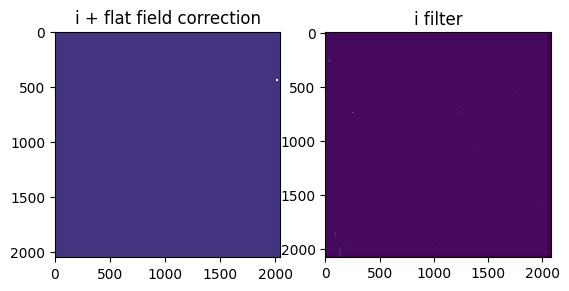

In [148]:
# DEBUGGING CELL !!!!! #

# checking if this thing actually worked (images)
plt.subplot(1, 2, 1)
plt.imshow(correctIImg[0])
plt.title('i + flat field correction')
plt.subplot(1, 2, 2)
plt.imshow(iFilter[0])
plt.title('i filter')

print(np.min(correctIImg[0]))
print(np.min(iFilter[0].data))

# saving as fits file

correctIImg[0].write(f'medianDomeFlat{filter}.fits', overwrite=True)
correctISky[1].write(f'correctSky.fits', overwrite=True)
# why does it look like ass.

In [ ]:
# generating a median sky flat for each filter by defining a new function
def medSkyFlat(filename, filter):
    # taking median values
    medSky = [np.median(flat.data) for flat in filename]
    # normalizing flat frames by dividing each by the median value
    normalizedSky = [flat.data / median for flat, median in zip(filename, medSky)]
        
    # applying sigma clipping to normalized flats
    sigClipSky = [sigma_clip(frame, sigma=3) for frame in normalizedSky]
    
    # stacking the frames, first by weighing each by its own median value
    weightFrames = [frame * median for frame, median in zip(sigClipSky, medSky)]
    # stacking these
    stackedSky = np.stack(np.array([frame.data for frame in weightFrames]), axis=0)

    # taking median
    medFlat = np.median(stackedSky, axis=0)

    # turning into a CCD
    masterSkyCCD = CCDData(medFlat, unit='adu')

    # saving each fits file
    masterSkyCCD.write(f'medianSkyFlat{filter}.fits', overwrite=True)

    return masterSkyCCD

medSkyFlatR = medSkyFlat(skyTrimmedR, 'R')
medSkyFlatI = medSkyFlat(skyTrimmedI, 'I')
medSkyFlatZ = medSkyFlat(skyTrimmedZ, 'Z')

# testing
print('Median of good master pixels:', np.median(medSkyFlatR.data.flatten()))
print('STD of good master pixels:', np.std(medSkyFlatR.data.flatten()))
print('Mean of good master pixels:', np.mean(medSkyFlatR.data.flatten()))

Median of good master pixels: 149.14857350096736
STD of good master pixels: 171.851212837928
Mean of good master pixels: 148.5337920138231


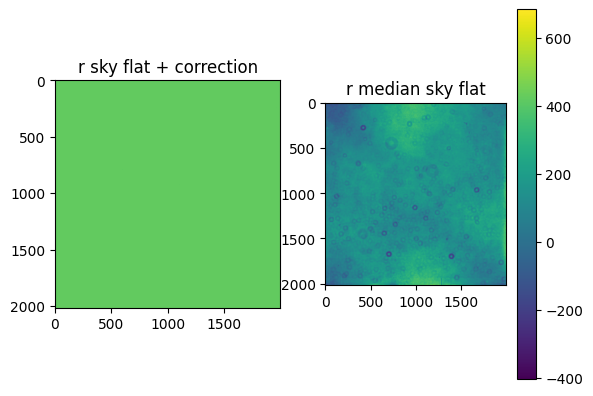

In [ ]:
# checking if this thing actually worked (images)
plt.subplot(1, 2, 1)
plt.imshow(correctRSky[0])
plt.title('r sky flat + correction')
plt.subplot(1, 2, 2)
plt.imshow(medSkyFlatR)
plt.title('r median sky flat')
plt.colorbar()

In [ ]:
# smoothing the sky flats
smoothSkyR = ccdproc.median_filter(medSkyFlatR, size=20)
smoothSkyI = ccdproc.median_filter(medSkyFlatI, size=20)
smoothSkyZ = ccdproc.median_filter(medSkyFlatZ, size=20)
# honestly 20 looks like the best, everything above that takes far too long to render & kinda looks bad

# saving them as fits files
smoothSkyR.write('medianSkyFlatSmoothR.fits', overwrite=True)
smoothSkyI.write('medianSkyFlatSmoothI.fits', overwrite=True)
smoothSkyZ.write('medianSkyFlatSmoothZ.fits', overwrite=True)

Text(0.5, 1.0, 'smoothed z')

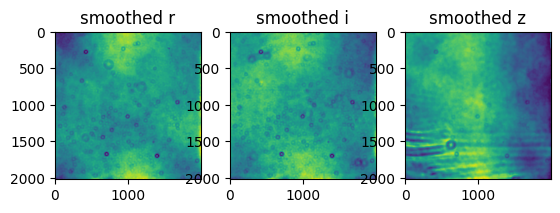

In [ ]:
# plotting each smoothed file
plt.subplot(1, 3, 1)
plt.imshow(smoothSkyR)
plt.title('smoothed r')
plt.subplot(1, 3, 2)
plt.imshow(smoothSkyI)
plt.title('smoothed i')
plt.subplot(1, 3, 3)
plt.imshow(smoothSkyZ)
plt.title('smoothed z')